<a target="_blank" href="https://colab.research.google.com/github/CompOmics/D012554A_2025/blob/main/notebooks/day_2/2.0_Regularization.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

np.random.seed(42)

# Regularization — Why it matters and how it works

In the previous notebooks we fitted models to data.  We saw that more flexible
models (e.g. higher-degree polynomials, deeper decision trees) can capture
complex patterns — but they can also memorise noise in the training set and
perform poorly on new data.  This is *overfitting*.

Regularization is a family of techniques that deliberately constrain or penalise
the complexity of a model so that it generalises better.  In this notebook we
will build visual intuition for:

1. Why unregularized models overfit.
2. How Ridge (L2) and Lasso (L1) regularization prevent overfitting in
   regression.
3. How the regularization strength $C$ controls the bias-variance trade-off in
   logistic regression.

---
## Part 1 — Regularization in linear regression

### 1.1  A synthetic dataset

We start by generating a simple 1-D dataset from a known function so that we
can see exactly where the "truth" lies.

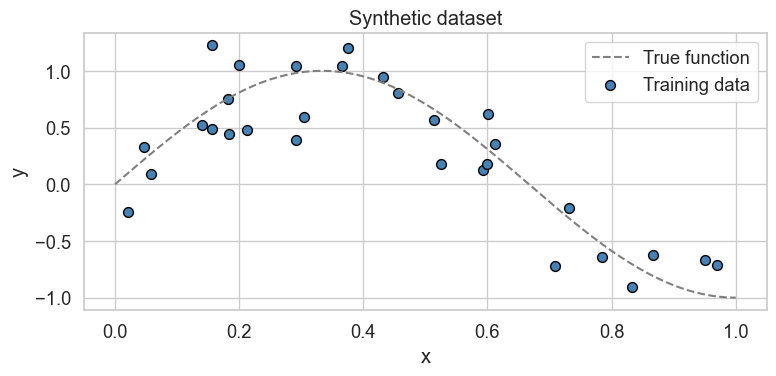

In [2]:
# True underlying function
def true_function(x):
    return np.sin(1.5 * np.pi * x)

n_samples = 30
X = np.sort(np.random.rand(n_samples))
y = true_function(X) + np.random.randn(n_samples) * 0.3

# Dense grid for plotting the true curve
X_plot = np.linspace(0, 1, 300)

plt.figure(figsize=(8, 4))
plt.plot(X_plot, true_function(X_plot), label="True function", color="grey",
         linestyle="--")
plt.scatter(X, y, color="steelblue", edgecolor="k", s=50, label="Training data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Synthetic dataset")
plt.tight_layout()
plt.show()

### 1.2  Overfitting with a high-degree polynomial

We will fit polynomial models of increasing degree to this data.  A degree-1
polynomial is a straight line (too simple, underfitting); a degree-15
polynomial can wiggle wildly and memorise the noise (overfitting).

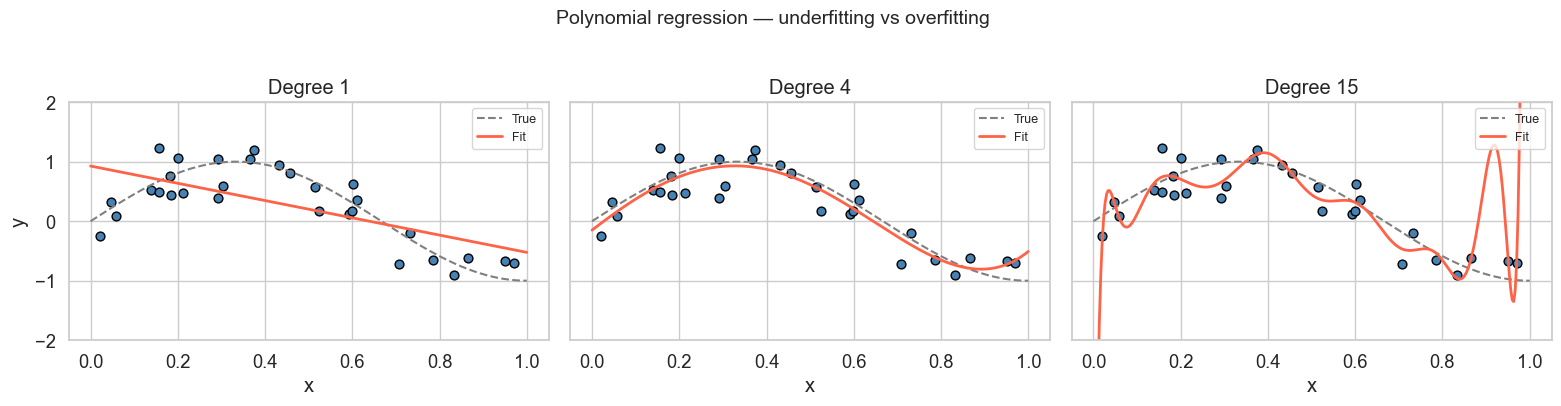

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

degrees = [1, 4, 15]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, degree in zip(axes, degrees):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X[:, np.newaxis], y)
    y_pred = model.predict(X_plot[:, np.newaxis])

    ax.plot(X_plot, true_function(X_plot), color="grey", linestyle="--",
            label="True")
    ax.scatter(X, y, color="steelblue", edgecolor="k", s=40)
    ax.plot(X_plot, y_pred, color="tomato", linewidth=2, label="Fit")
    ax.set_ylim(-2, 2)
    ax.set_title(f"Degree {degree}")
    ax.set_xlabel("x")
    ax.legend(loc="upper right", fontsize=9)

axes[0].set_ylabel("y")
fig.suptitle("Polynomial regression — underfitting vs overfitting",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

The degree-15 polynomial passes almost exactly through every training point,
but between those points it oscillates wildly.  The coefficients of such a
model are very large — let's verify:

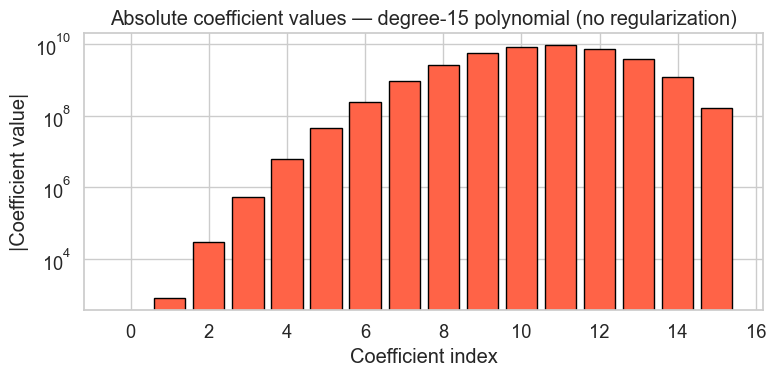

Sum of squared coefficients: 2.74e+20


In [4]:
model_15 = make_pipeline(PolynomialFeatures(15), LinearRegression())
model_15.fit(X[:, np.newaxis], y)
coefs = model_15.named_steps['linearregression'].coef_

plt.figure(figsize=(8, 4))
plt.bar(range(len(coefs)), np.abs(coefs), color="tomato", edgecolor="k")
plt.xlabel("Coefficient index")
plt.ylabel("|Coefficient value|")
plt.title("Absolute coefficient values — degree-15 polynomial (no regularization)")
plt.yscale("log")
plt.tight_layout()
plt.show()

print(f"Sum of squared coefficients: {np.sum(coefs ** 2):.2e}")

When a polynomial overfits, the coefficients blow up because the model needs
extreme weights to thread through every noisy data point.  Regularization fixes
this by adding a penalty term that discourages large coefficients.

### 1.3  The idea behind regularization

In ordinary least squares we minimise the residual sum of squares:

$$
\text{RSS} = \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
$$

Regularization adds a penalty on the size of the coefficients $\mathbf{w}$:

| Method | Loss function |
|--------|---------------|
| Ridge (L2) | $\text{RSS} + \alpha \sum_j w_j^2$ |
| Lasso (L1) | $\text{RSS} + \alpha \sum_j \lvert w_j \rvert$ |

- $\alpha$ controls the regularization strength.  Larger $\alpha$ → stronger
  penalty → simpler model.
- Ridge shrinks coefficients toward zero but keeps all of them.
- Lasso can shrink coefficients all the way to zero — it performs *feature
  selection*.

### 1.4  Visualizing the loss landscape

To build geometric intuition, let us create a tiny regression problem with just
two weights ($w_1$, $w_2$) so that we can plot the loss as a 2-D contour map.
Each contour line connects points in weight space that share the same loss.

When we add a regularization penalty, the landscape changes: Ridge adds a
circular "bowl" centred at the origin, while Lasso adds a diamond-shaped
"tent".  The stronger the penalty ($\alpha$), the more the optimum is pulled
toward the origin.

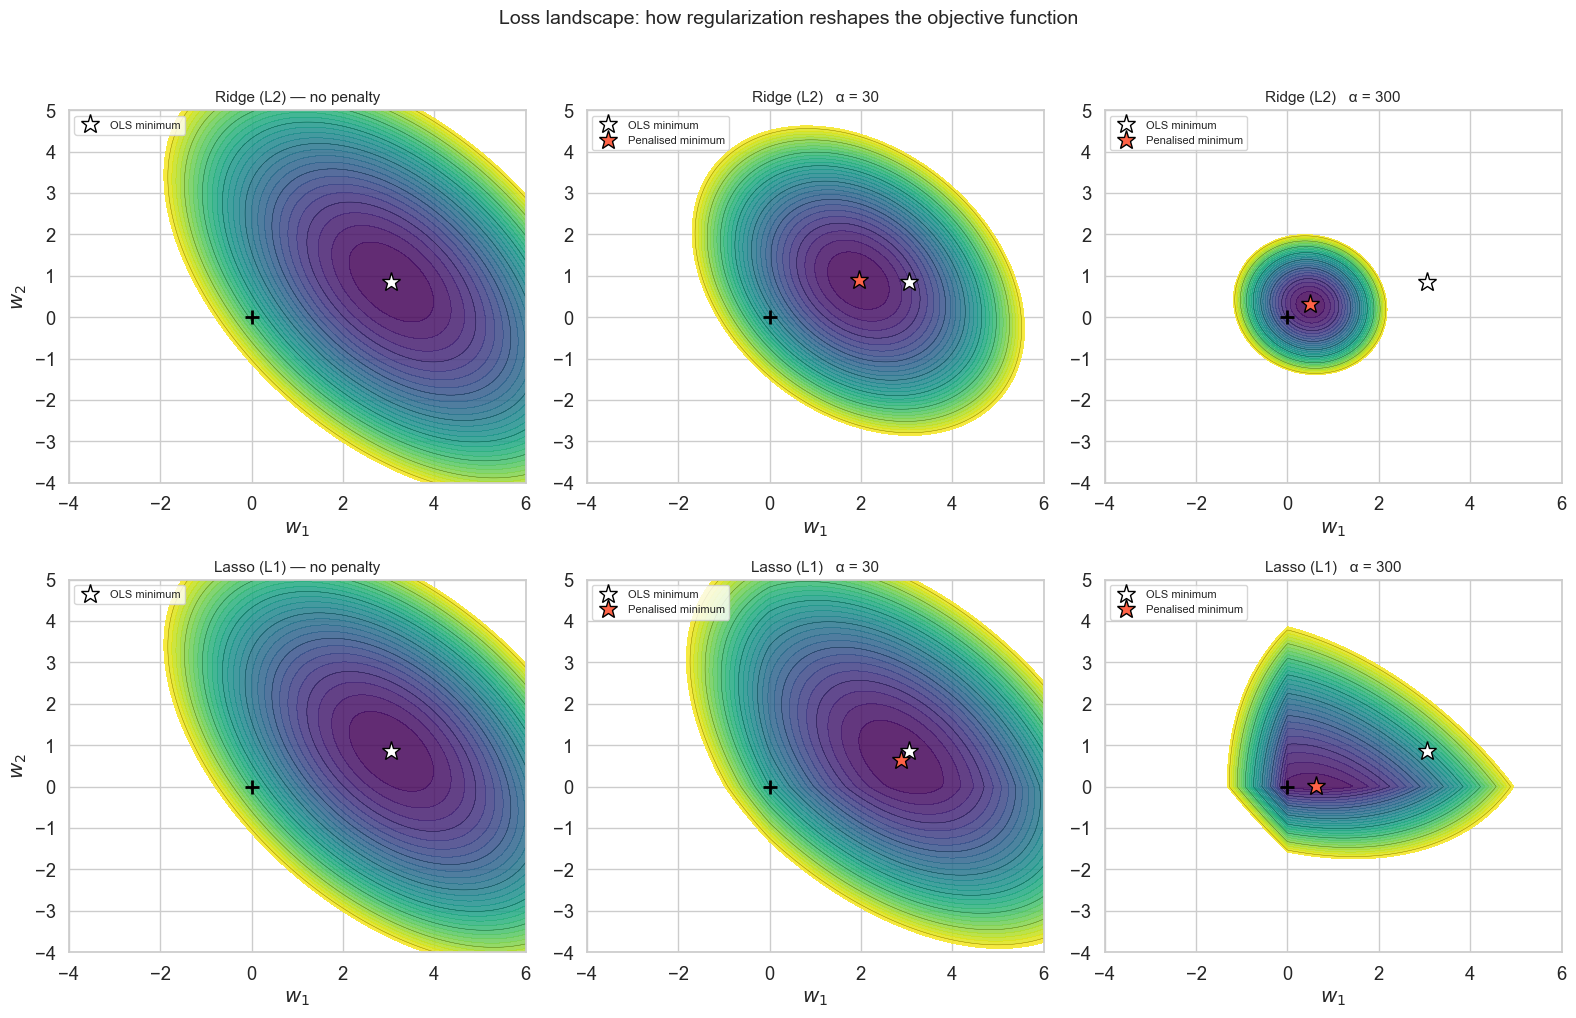

OLS solution: w₁ = 3.06, w₂ = 0.85


In [2]:
# --- A simple 2-feature regression for loss-landscape visualisation ---
np.random.seed(0)
n_ls = 50
X_ls = np.random.randn(n_ls, 2)
X_ls[:, 1] = 0.5 * X_ls[:, 0] + np.sqrt(0.75) * X_ls[:, 1]
w_true_ls = np.array([3.0, 1.0])
y_ls = X_ls @ w_true_ls + np.random.randn(n_ls) * 2.0

w_ols = np.linalg.lstsq(X_ls, y_ls, rcond=None)[0]

# RSS in closed form on a weight grid
XtX = X_ls.T @ X_ls
Xty = X_ls.T @ y_ls
yty = float(y_ls @ y_ls)

w0_g = np.linspace(-4, 6, 500)
w1_g = np.linspace(-4, 5, 500)
W0, W1 = np.meshgrid(w0_g, w1_g)

RSS_grid = (yty
            - 2 * (Xty[0] * W0 + Xty[1] * W1)
            + XtX[0, 0] * W0**2
            + 2 * XtX[0, 1] * W0 * W1
            + XtX[1, 1] * W1**2)

# --- Contour plots: Ridge (top) and Lasso (bottom) at three alpha levels ---
alpha_vals = [0, 30, 300]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for row, (pen_name, pen_fn) in enumerate([
    ("Ridge (L2)", lambda a: a * (W0**2 + W1**2)),
    ("Lasso (L1)", lambda a: a * (np.abs(W0) + np.abs(W1))),
]):
    for col, alpha in enumerate(alpha_vals):
        ax = axes[row, col]
        total = RSS_grid + pen_fn(alpha)

        idx = np.unravel_index(np.argmin(total), total.shape)
        w_min = [W0[idx], W1[idx]]

        lo = total[idx]
        spread = (RSS_grid.max() - RSS_grid.min()) * 0.18
        levels = np.linspace(lo, lo + spread, 30)

        ax.contourf(W0, W1, total, levels=levels, cmap="viridis", alpha=0.85)
        ax.contour(W0, W1, total, levels=levels[::4], colors="k",
                   linewidths=0.3, alpha=0.5)
        ax.plot(*w_ols, 'w*', ms=14, mec='k', mew=1, zorder=5,
                label="OLS minimum")
        if alpha > 0:
            ax.plot(*w_min, '*', color='tomato', ms=14, mec='k', mew=1,
                    zorder=5, label="Penalised minimum")
        ax.plot(0, 0, 'k+', ms=10, mew=2, zorder=5)
        ax.set_xlabel("$w_1$")
        if col == 0:
            ax.set_ylabel("$w_2$")

        title = (f"{pen_name} — no penalty" if alpha == 0
                 else f"{pen_name}   α = {alpha}")
        ax.set_title(title, fontsize=11)
        ax.legend(fontsize=8, loc="upper left")

fig.suptitle("Loss landscape: how regularization reshapes the objective function",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"OLS solution: w₁ = {w_ols[0]:.2f}, w₂ = {w_ols[1]:.2f}")

Observe how the minimum (red star) moves from the OLS solution (white star)
toward the origin as $\alpha$ increases.  For Ridge (top row), the minimum
follows a smooth path.  For Lasso (bottom row), notice that one coefficient
reaches zero before the other — the minimum "snaps" to an axis.

We can make this even clearer with the classic *constraint-region* view: draw
the RSS contour ellipses (centred at the OLS solution) together with the
penalty region centred at the origin.  The constrained optimum is the point
where the smallest RSS contour just touches the penalty region.

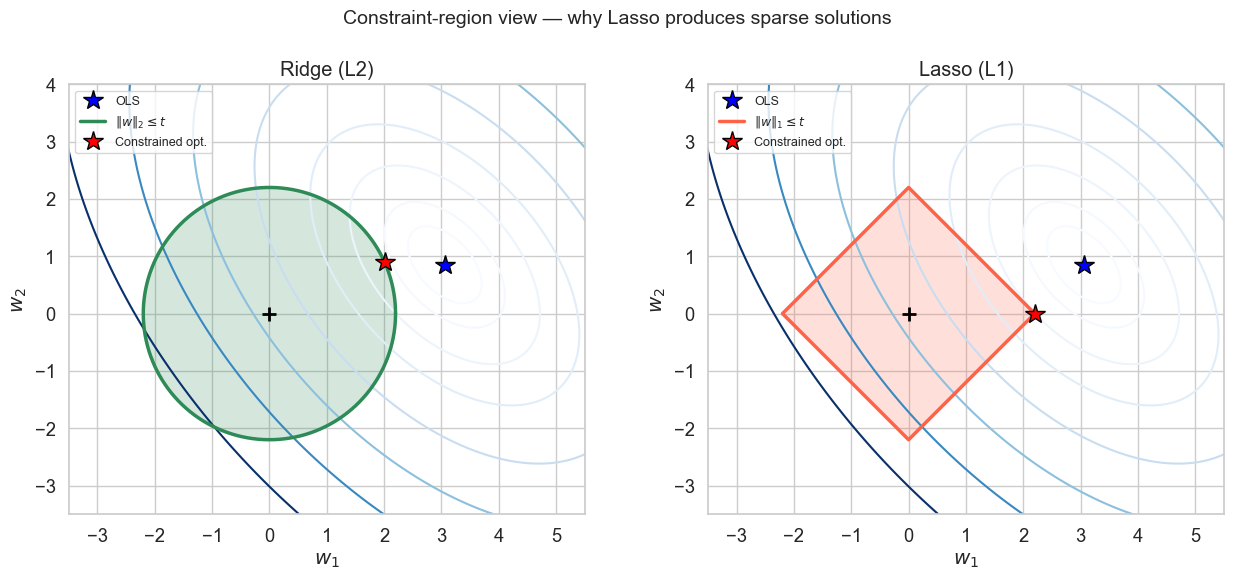

Ridge constrained:  w₁ = 2.01, w₂ = 0.89  (‖w‖₂ = 2.20)
Lasso constrained:  w₁ = 2.20, w₂ = 0.00  (‖w‖₁ = 2.20)


In [3]:
# --- Constraint-region view (ESL / ISLR style) ---
budget = 2.2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.5))

# RSS contour levels (expanding outward from the OLS minimum)
rss_min = RSS_grid.min()
rss_spread = RSS_grid.max() - rss_min
levels_rss = rss_min + rss_spread * np.array(
    [0.003, 0.008, 0.02, 0.04, 0.08, 0.14, 0.22, 0.33])

for ax in [ax1, ax2]:
    ax.contour(W0, W1, RSS_grid, levels=levels_rss, cmap="Blues",
               linewidths=1.5)
    ax.plot(*w_ols, 'b*', ms=15, mec='k', mew=1, zorder=5, label="OLS")
    ax.plot(0, 0, 'k+', ms=10, mew=2, zorder=4)
    ax.set_xlabel("$w_1$")
    ax.set_ylabel("$w_2$")
    ax.set_aspect("equal")
    ax.set_xlim(-3.5, 5.5)
    ax.set_ylim(-3.5, 4.0)

# ---- L2 (Ridge) ----
theta = np.linspace(0, 2 * np.pi, 300)
ax1.fill(budget * np.cos(theta), budget * np.sin(theta),
         alpha=0.2, color="seagreen")
ax1.plot(budget * np.cos(theta), budget * np.sin(theta),
         color="seagreen", linewidth=2.5,
         label=r"$\|w\|_2 \leq t$")

# Ridge constrained solution (binary search on regularization parameter)
lo_a, hi_a = 0.0, 1e4
for _ in range(100):
    mid_a = (lo_a + hi_a) / 2
    w_try = np.linalg.solve(XtX + mid_a * np.eye(2), Xty)
    if np.linalg.norm(w_try) > budget:
        lo_a = mid_a
    else:
        hi_a = mid_a
w_ridge_c = np.linalg.solve(XtX + lo_a * np.eye(2), Xty)

ax1.plot(w_ridge_c[0], w_ridge_c[1], 'r*', ms=15, mec='k', mew=1,
         zorder=5, label="Constrained opt.")
ax1.set_title("Ridge (L2)")
ax1.legend(fontsize=9, loc="upper left")

# ---- L1 (Lasso) ----
diamond = np.array([[budget, 0], [0, budget], [-budget, 0],
                    [0, -budget], [budget, 0]])
ax2.fill(diamond[:, 0], diamond[:, 1], alpha=0.2, color="tomato")
ax2.plot(diamond[:, 0], diamond[:, 1], color="tomato", linewidth=2.5,
         label=r"$\|w\|_1 \leq t$")

# Lasso constrained solution (binary search on alpha)
from sklearn.linear_model import Lasso as LassoSK
lo_a, hi_a = 0.0, 100.0
for _ in range(100):
    mid_a = (lo_a + hi_a) / 2
    lasso_m = LassoSK(alpha=mid_a, max_iter=10000, fit_intercept=False)
    lasso_m.fit(X_ls, y_ls)
    if np.sum(np.abs(lasso_m.coef_)) > budget:
        lo_a = mid_a
    else:
        hi_a = mid_a
w_lasso_c = lasso_m.coef_

ax2.plot(w_lasso_c[0], w_lasso_c[1], 'r*', ms=15, mec='k', mew=1,
         zorder=5, label="Constrained opt.")
ax2.set_title("Lasso (L1)")
ax2.legend(fontsize=9, loc="upper left")

fig.suptitle("Constraint-region view — why Lasso produces sparse solutions",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"Ridge constrained:  w₁ = {w_ridge_c[0]:.2f}, w₂ = {w_ridge_c[1]:.2f}  "
      f"(‖w‖₂ = {np.linalg.norm(w_ridge_c):.2f})")
print(f"Lasso constrained:  w₁ = {w_lasso_c[0]:.2f}, w₂ = {w_lasso_c[1]:.2f}  "
      f"(‖w‖₁ = {np.sum(np.abs(w_lasso_c)):.2f})")

This is the geometric reason why Lasso performs feature selection: the
diamond-shaped L1 constraint region has *corners* on the axes, and the first
RSS contour to touch the constraint region tends to hit a corner — setting one
or more weights exactly to zero.  The circular L2 region has no such corners,
so the tangent point generally keeps all weights non-zero (just smaller).

### 1.5  Ridge vs Lasso on the polynomial data

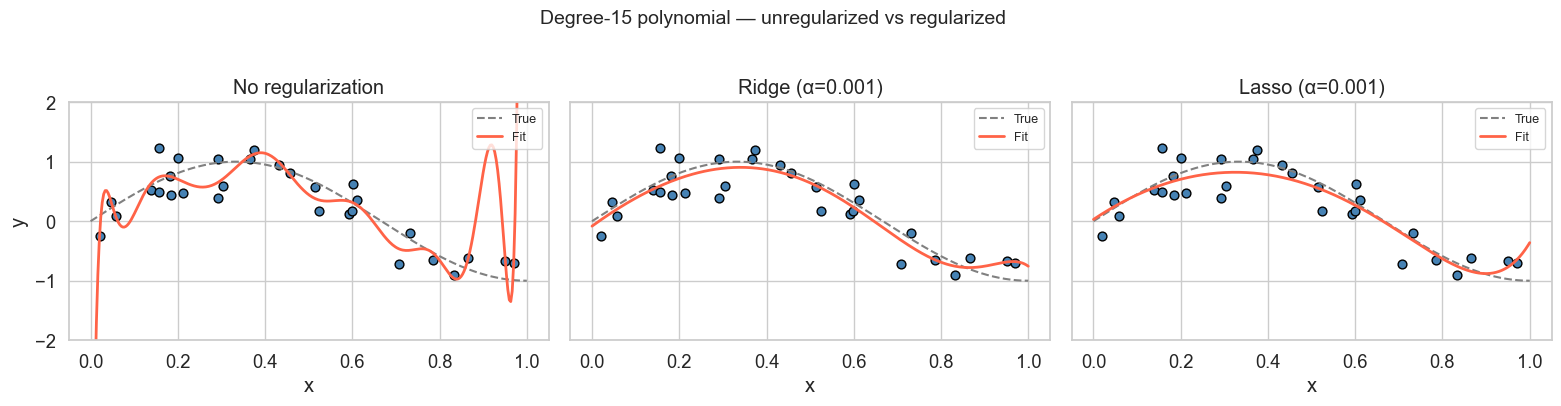

In [5]:
from sklearn.linear_model import Ridge, Lasso

degree = 15
alpha = 1e-3  # a moderate penalty

models = {
    "No regularization": make_pipeline(PolynomialFeatures(degree),
                                       LinearRegression()),
    f"Ridge (α={alpha})": make_pipeline(PolynomialFeatures(degree),
                                        Ridge(alpha=alpha)),
    f"Lasso (α={alpha})": make_pipeline(PolynomialFeatures(degree),
                                        Lasso(alpha=alpha, max_iter=50000)),
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, (name, model) in zip(axes, models.items()):
    model.fit(X[:, np.newaxis], y)
    y_pred = model.predict(X_plot[:, np.newaxis])

    ax.plot(X_plot, true_function(X_plot), color="grey", linestyle="--",
            label="True")
    ax.scatter(X, y, color="steelblue", edgecolor="k", s=40)
    ax.plot(X_plot, y_pred, color="tomato", linewidth=2, label="Fit")
    ax.set_ylim(-2, 2)
    ax.set_title(name)
    ax.set_xlabel("x")
    ax.legend(loc="upper right", fontsize=9)

axes[0].set_ylabel("y")
fig.suptitle("Degree-15 polynomial — unregularized vs regularized",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Even though all three models use a degree-15 polynomial, the Ridge and Lasso
fits are much smoother because their penalty term pulls the coefficients toward
zero, preventing the wild oscillations.

### 1.6  Coefficient paths — how coefficients shrink with $\alpha$

One of the most informative regularization plots is the *coefficient path*:
we vary $\alpha$ from very small (≈ ordinary least squares) to very large
(all coefficients crushed to zero) and watch what happens.

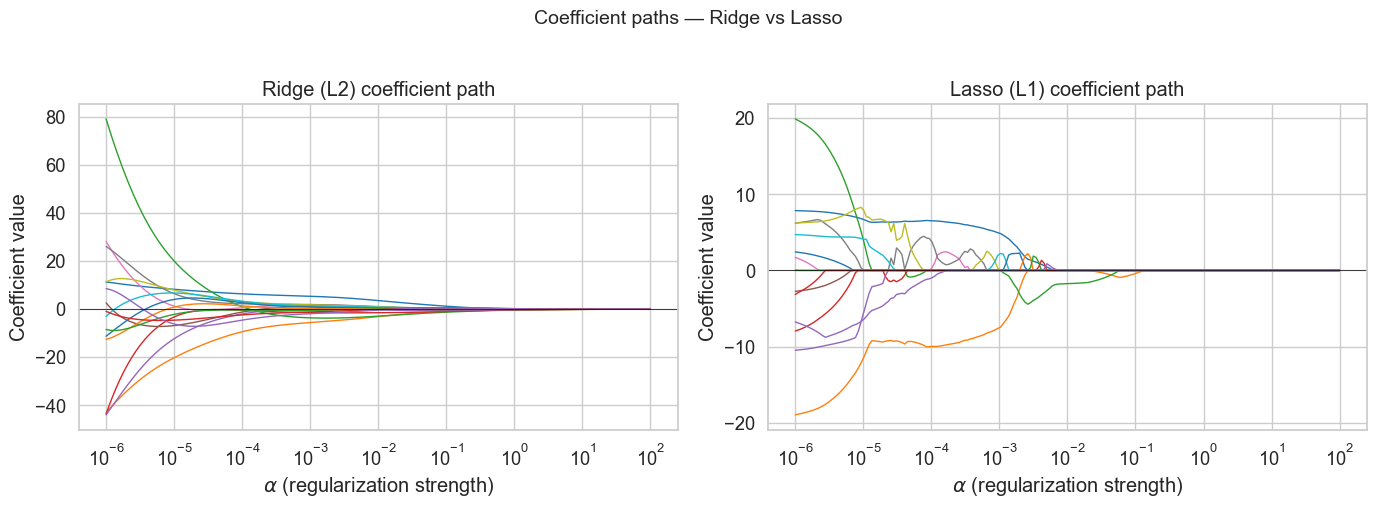

In [6]:
alphas = np.logspace(-6, 2, 200)
degree = 15

poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X[:, np.newaxis])

# --- Ridge coefficient path ---
ridge_coefs = []
for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_poly, y)
    ridge_coefs.append(model.coef_[1:])  # skip intercept duplicate at index 0
ridge_coefs = np.array(ridge_coefs)

# --- Lasso coefficient path ---
lasso_coefs = []
for a in alphas:
    model = Lasso(alpha=a, max_iter=50000)
    model.fit(X_poly, y)
    lasso_coefs.append(model.coef_[1:])
lasso_coefs = np.array(lasso_coefs)

# --- Plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i in range(ridge_coefs.shape[1]):
    ax1.plot(alphas, ridge_coefs[:, i], linewidth=1)
ax1.set_xscale("log")
ax1.set_xlabel(r"$\alpha$ (regularization strength)")
ax1.set_ylabel("Coefficient value")
ax1.set_title("Ridge (L2) coefficient path")
ax1.axhline(0, color="k", linewidth=0.5)

for i in range(lasso_coefs.shape[1]):
    ax2.plot(alphas, lasso_coefs[:, i], linewidth=1)
ax2.set_xscale("log")
ax2.set_xlabel(r"$\alpha$ (regularization strength)")
ax2.set_ylabel("Coefficient value")
ax2.set_title("Lasso (L1) coefficient path")
ax2.axhline(0, color="k", linewidth=0.5)

fig.suptitle("Coefficient paths — Ridge vs Lasso", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Notice the key difference:

- Ridge gradually shrinks all coefficients toward zero, but they never become
  exactly zero.
- Lasso drives many coefficients to exactly zero as $\alpha$ increases.  This
  is automatic feature selection — only the most important features survive.

### 1.7  Choosing $\alpha$ — the bias-variance trade-off

Too little regularization → overfitting (high variance, low bias).  
Too much regularization → underfitting (low variance, high bias).  

We use cross-validation to find the sweet spot.

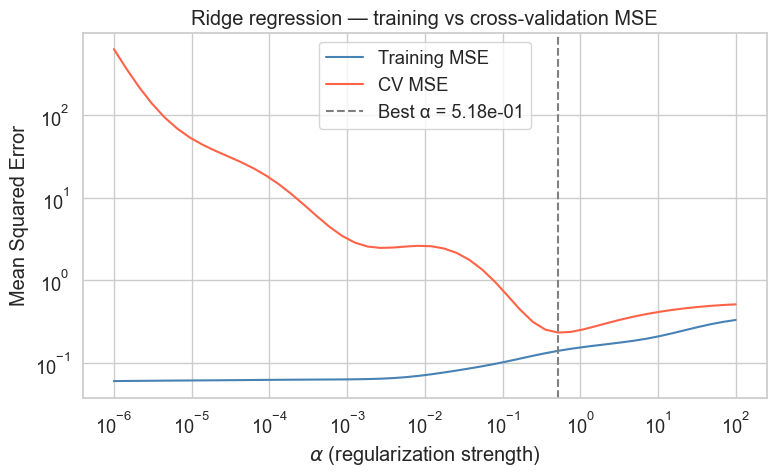

Best α by 5-fold CV: 5.18e-01  (CV MSE = 0.2328)


In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

alphas_cv = np.logspace(-6, 2, 50)
degree = 15

train_mse = []
cv_mse = []

for a in alphas_cv:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=a))
    model.fit(X[:, np.newaxis], y)
    train_mse.append(mean_squared_error(y, model.predict(X[:, np.newaxis])))
    scores = cross_val_score(model, X[:, np.newaxis], y, cv=5,
                             scoring="neg_mean_squared_error")
    cv_mse.append(-scores.mean())

best_idx = np.argmin(cv_mse)
best_alpha = alphas_cv[best_idx]

plt.figure(figsize=(8, 5))
plt.plot(alphas_cv, train_mse, label="Training MSE", color="steelblue")
plt.plot(alphas_cv, cv_mse, label="CV MSE", color="tomato")
plt.axvline(best_alpha, color="grey", linestyle="--",
            label=f"Best α = {best_alpha:.2e}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\alpha$ (regularization strength)")
plt.ylabel("Mean Squared Error")
plt.title("Ridge regression — training vs cross-validation MSE")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best α by 5-fold CV: {best_alpha:.2e}  (CV MSE = {cv_mse[best_idx]:.4f})")

The training error increases as $\alpha$ increases (the model is forced to be
simpler), while the cross-validation error first drops (less overfitting) and
then rises again (too much underfitting).  The optimal $\alpha$ sits at the
minimum of the CV curve.

### 1.8  Putting it all together — best Ridge fit

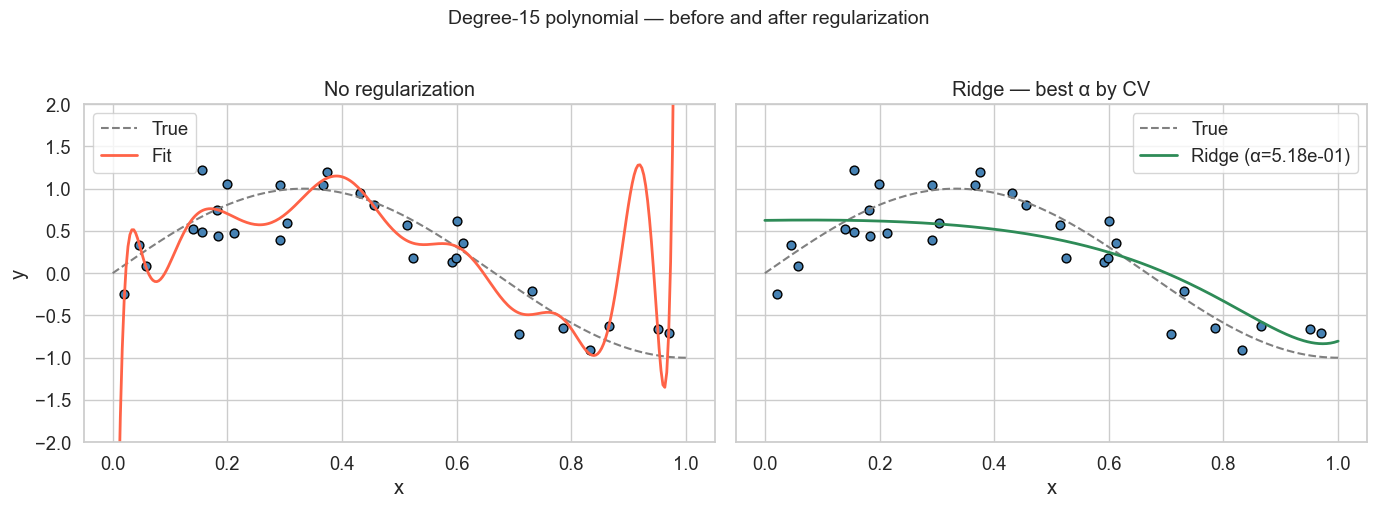

In [9]:
best_model = make_pipeline(PolynomialFeatures(degree),
                           Ridge(alpha=best_alpha))
best_model.fit(X[:, np.newaxis], y)
y_best = best_model.predict(X_plot[:, np.newaxis])

unreg_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
unreg_model.fit(X[:, np.newaxis], y)
y_unreg = unreg_model.predict(X_plot[:, np.newaxis])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# No regularization
ax1.plot(X_plot, true_function(X_plot), color="grey", linestyle="--",
         label="True")
ax1.scatter(X, y, color="steelblue", edgecolor="k", s=40)
ax1.plot(X_plot, y_unreg, color="tomato", linewidth=2, label="Fit")
ax1.set_ylim(-2, 2)
ax1.set_title("No regularization")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.legend()

# Best Ridge
ax2.plot(X_plot, true_function(X_plot), color="grey", linestyle="--",
         label="True")
ax2.scatter(X, y, color="steelblue", edgecolor="k", s=40)
ax2.plot(X_plot, y_best, color="seagreen", linewidth=2,
         label=f"Ridge (α={best_alpha:.2e})")
ax2.set_ylim(-2, 2)
ax2.set_title(f"Ridge — best α by CV")
ax2.set_xlabel("x")
ax2.legend()

fig.suptitle("Degree-15 polynomial — before and after regularization",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## Part 2 — Regularization in logistic regression

Regularization applies to classification models too.
Scikit-learn's `LogisticRegression` uses the parameter $C = 1 / \alpha$:

- Small $C$ → strong regularization (simpler model).
- Large $C$ → weak regularization (more complex model).

We will visualize this using a 2-D dataset so that we can plot decision
boundaries.

### 2.1  A 2-D classification dataset

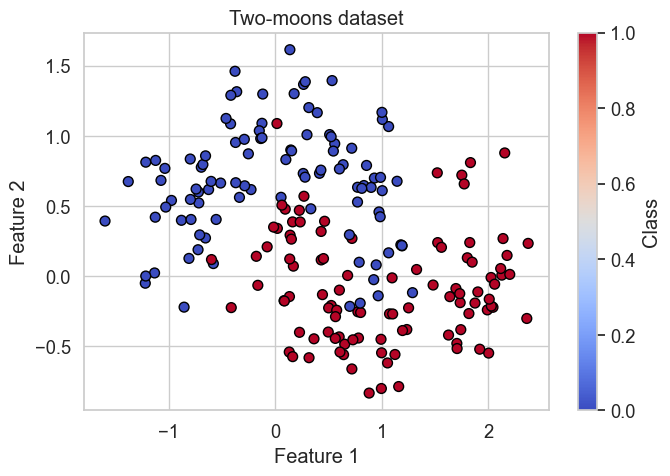

In [10]:
from sklearn.datasets import make_moons

X_clf, y_clf = make_moons(n_samples=200, noise=0.25, random_state=42)

plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_clf[:, 0], X_clf[:, 1], c=y_clf,
                      cmap="coolwarm", edgecolor="k", s=50)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Two-moons dataset")
plt.colorbar(scatter, label="Class")
plt.tight_layout()
plt.show()

This non-linear dataset is not linearly separable.  We will add polynomial
features (just like in Part 1) to make the logistic regression model flexible
enough to capture the curved boundary — and then regularization will prevent
it from memorising the noise.

### 2.2  Decision boundaries at different regularization strengths

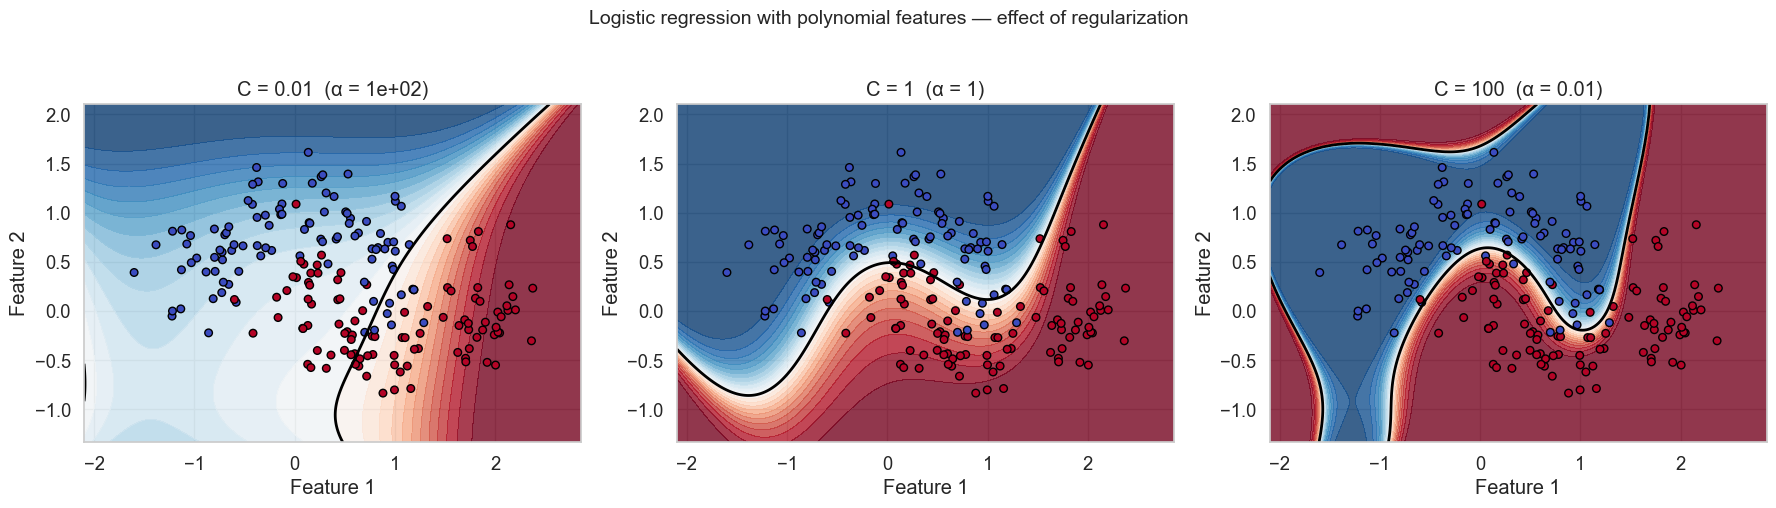

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def plot_decision_boundary(ax, model, X, y, title):
    """Plot the decision boundary and probability surface."""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, levels=np.linspace(0, 1, 25), cmap="RdBu_r",
                alpha=0.8)
    ax.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=2)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=30)
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


C_values = [0.01, 1, 100]
degree = 4

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, C in zip(axes, C_values):
    model = make_pipeline(
        PolynomialFeatures(degree),
        LogisticRegression(C=C, max_iter=5000, solver="lbfgs")
    )
    model.fit(X_clf, y_clf)
    plot_decision_boundary(ax, model, X_clf, y_clf,
                           f"C = {C}  (α = {1/C:.2g})")

fig.suptitle("Logistic regression with polynomial features — effect of regularization",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

- $C = 0.01$ (strong regularization): the boundary is very smooth, perhaps too
  simple — it misclassifies some clearly separable points.
- $C = 1$ (moderate): a good balance — the boundary is flexible enough to
  capture the moon shapes without overfitting.
- $C = 100$ (weak regularization): the boundary becomes noisy and jagged,
  trying to correctly classify every single training point.

### 2.3  Coefficient magnitudes vs regularization strength

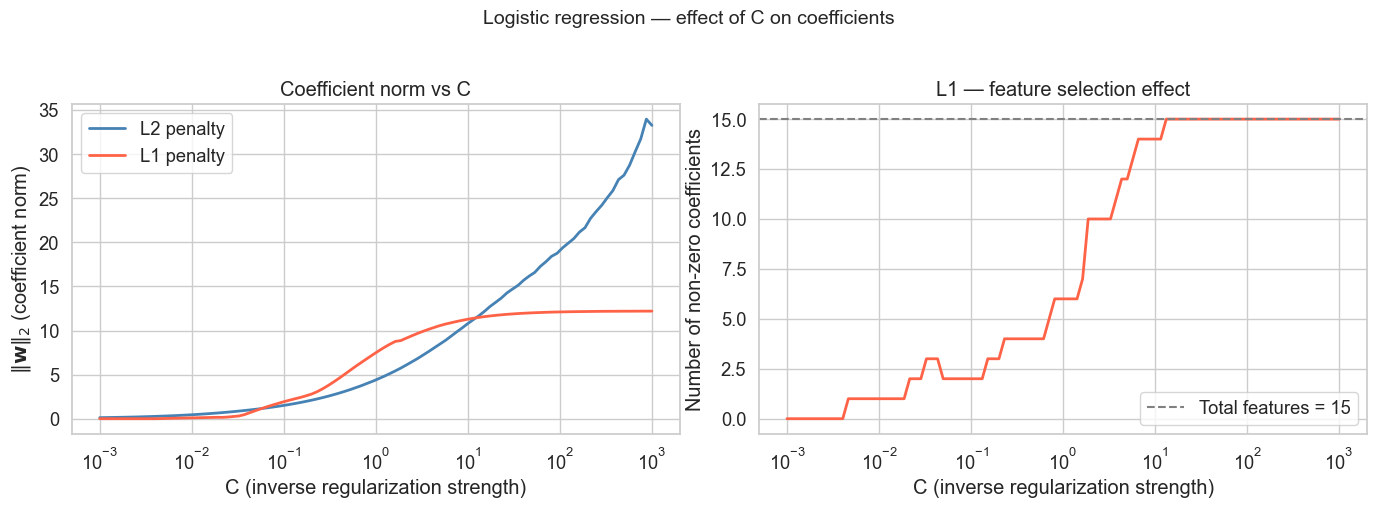

In [12]:
C_range = np.logspace(-3, 3, 100)
degree = 4

coef_norms_l1 = []
coef_norms_l2 = []
n_nonzero_l1 = []

poly = PolynomialFeatures(degree)
X_clf_poly = poly.fit_transform(X_clf)

for C in C_range:
    # L2 (Ridge-type)
    lr_l2 = LogisticRegression(C=C, penalty="l2", max_iter=5000,
                               solver="lbfgs")
    lr_l2.fit(X_clf_poly, y_clf)
    coef_norms_l2.append(np.linalg.norm(lr_l2.coef_))

    # L1 (Lasso-type)
    lr_l1 = LogisticRegression(C=C, penalty="l1", max_iter=5000,
                               solver="saga")
    lr_l1.fit(X_clf_poly, y_clf)
    coef_norms_l1.append(np.linalg.norm(lr_l1.coef_))
    n_nonzero_l1.append(np.sum(np.abs(lr_l1.coef_) > 1e-6))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(C_range, coef_norms_l2, label="L2 penalty", color="steelblue",
         linewidth=2)
ax1.plot(C_range, coef_norms_l1, label="L1 penalty", color="tomato",
         linewidth=2)
ax1.set_xscale("log")
ax1.set_xlabel("C (inverse regularization strength)")
ax1.set_ylabel(r"$\|\mathbf{w}\|_2$ (coefficient norm)")
ax1.set_title("Coefficient norm vs C")
ax1.legend()

ax2.plot(C_range, n_nonzero_l1, color="tomato", linewidth=2)
ax2.set_xscale("log")
ax2.set_xlabel("C (inverse regularization strength)")
ax2.set_ylabel("Number of non-zero coefficients")
ax2.set_title("L1 — feature selection effect")
ax2.axhline(X_clf_poly.shape[1], color="grey", linestyle="--",
            label=f"Total features = {X_clf_poly.shape[1]}")
ax2.legend()

fig.suptitle("Logistic regression — effect of C on coefficients",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

- As $C$ increases (regularization weakens), both L1 and L2 allow coefficients
  to grow.
- The L1 penalty is especially interesting: with small $C$, only a handful of features
  have non-zero coefficients.  As we increase $C$, more features are "allowed in".

### 2.4  Validation curve — finding the best $C$

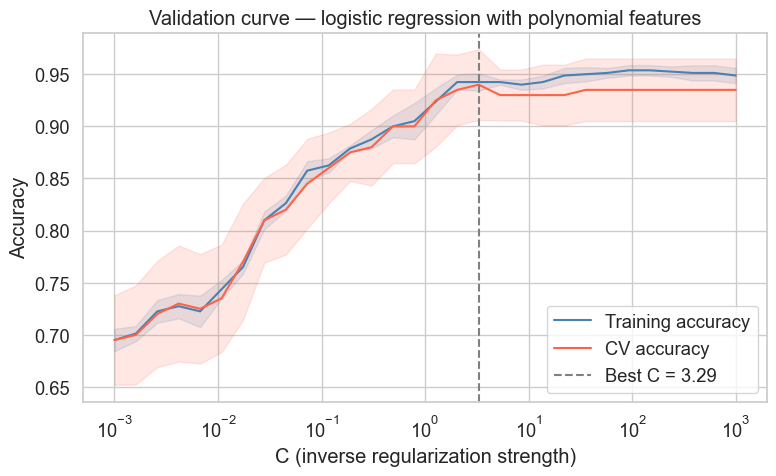

Best C = 3.29 (CV accuracy = 0.940)


In [13]:
from sklearn.model_selection import validation_curve

C_range_cv = np.logspace(-3, 3, 30)

pipeline = make_pipeline(
    PolynomialFeatures(degree),
    LogisticRegression(max_iter=5000, solver="lbfgs")
)

train_scores, val_scores = validation_curve(
    pipeline, X_clf, y_clf,
    param_name="logisticregression__C",
    param_range=C_range_cv,
    cv=5,
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(C_range_cv, train_mean, label="Training accuracy", color="steelblue")
plt.fill_between(C_range_cv, train_mean - train_std, train_mean + train_std,
                 alpha=0.15, color="steelblue")
plt.plot(C_range_cv, val_mean, label="CV accuracy", color="tomato")
plt.fill_between(C_range_cv, val_mean - val_std, val_mean + val_std,
                 alpha=0.15, color="tomato")

best_c_idx = np.argmax(val_mean)
plt.axvline(C_range_cv[best_c_idx], color="grey", linestyle="--",
            label=f"Best C = {C_range_cv[best_c_idx]:.2f}")

plt.xscale("log")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Accuracy")
plt.title("Validation curve — logistic regression with polynomial features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Best C = {C_range_cv[best_c_idx]:.2f} "
      f"(CV accuracy = {val_mean[best_c_idx]:.3f})")

The characteristic shape is the same as in Part 1:

- On the left (small $C$, strong regularization) the model is too constrained,
  so both training and validation accuracy are low → underfitting.
- On the right (large $C$, weak regularization) the model fits the training
  data very well, but the gap between training and validation grows →
  overfitting.
- The best $C$ sits in the middle.

---
## Part 3 — Regularization on a real dataset

Let's apply everything on a higher-dimensional real dataset — the
Breast Cancer Wisconsin dataset — to show that regularization helps in
practice, not just on toy examples.

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X_bc, y_bc = data.data, data.target

X_train, X_val, y_train, y_val = train_test_split(
    X_bc, y_bc, test_size=0.2, random_state=42, stratify=y_bc
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

print(f"Features: {X_bc.shape[1]}")
print(f"Training samples: {X_train_s.shape[0]}")
print(f"Validation samples: {X_val_s.shape[0]}")

Features: 30
Training samples: 455
Validation samples: 114


### 3.1  Coefficient comparison — no regularization vs Ridge vs Lasso

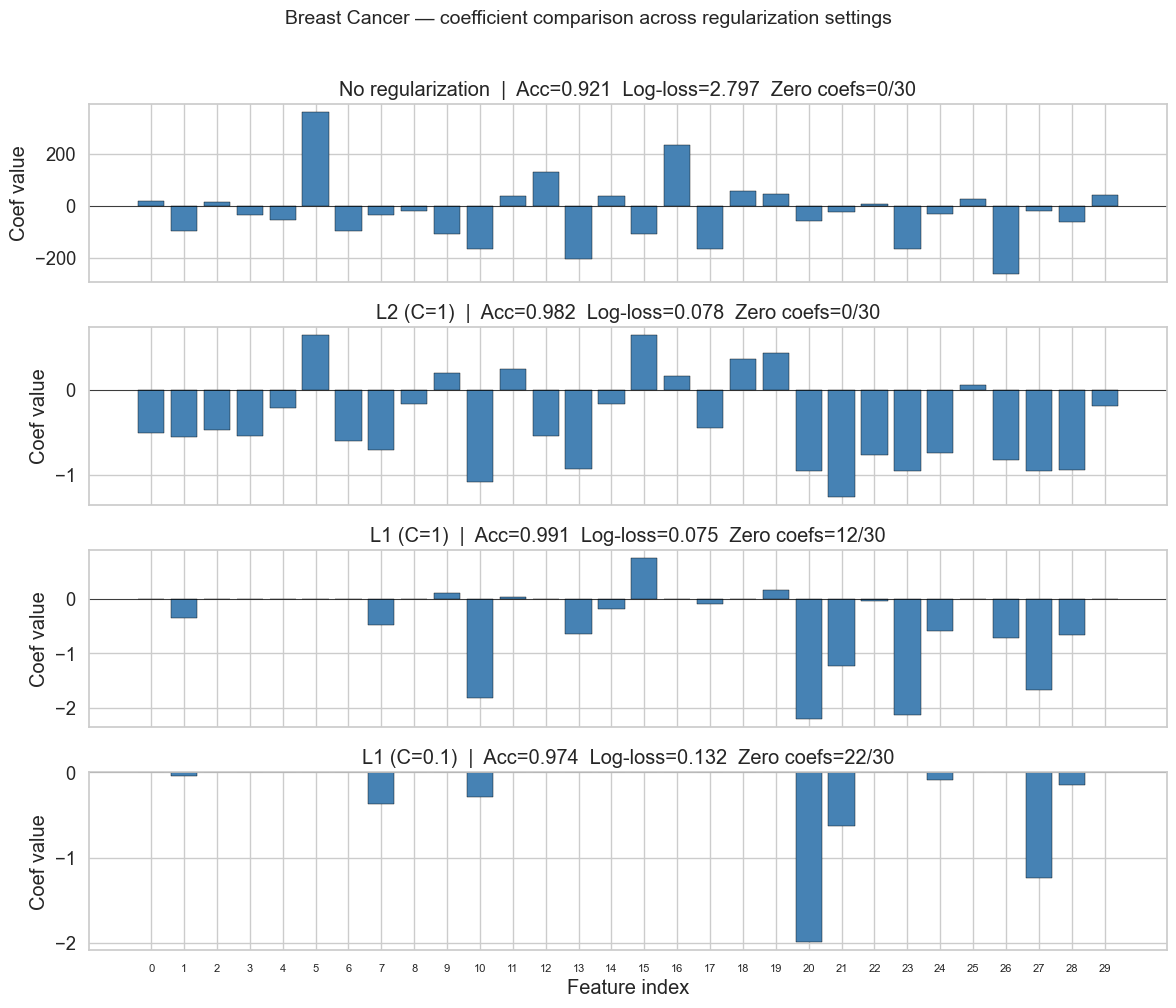

In [15]:
from sklearn.metrics import accuracy_score, log_loss

configs = [
    ("No regularization", LogisticRegression(penalty=None, max_iter=5000,
                                              solver="lbfgs")),
    ("L2 (C=1)",          LogisticRegression(penalty="l2", C=1,
                                              max_iter=5000, solver="lbfgs")),
    ("L1 (C=1)",          LogisticRegression(penalty="l1", C=1,
                                              max_iter=5000, solver="saga")),
    ("L1 (C=0.1)",        LogisticRegression(penalty="l1", C=0.1,
                                              max_iter=5000, solver="saga")),
]

fig, axes = plt.subplots(len(configs), 1, figsize=(12, 10), sharex=True)

for ax, (name, model) in zip(axes, configs):
    model.fit(X_train_s, y_train)
    coefs = model.coef_.ravel()
    n_zero = np.sum(np.abs(coefs) < 1e-6)

    y_pred = model.predict(X_val_s)
    y_prob = model.predict_proba(X_val_s)
    acc = accuracy_score(y_val, y_pred)
    ll = log_loss(y_val, y_prob)

    colors = ["tomato" if abs(c) < 1e-6 else "steelblue" for c in coefs]
    ax.bar(range(len(coefs)), coefs, color=colors, edgecolor="k",
           linewidth=0.3)
    ax.set_ylabel("Coef value")
    ax.set_title(f"{name}  |  Acc={acc:.3f}  Log-loss={ll:.3f}  "
                 f"Zero coefs={n_zero}/{len(coefs)}")
    ax.axhline(0, color="k", linewidth=0.5)

axes[-1].set_xlabel("Feature index")
axes[-1].set_xticks(range(len(data.feature_names)))
axes[-1].set_xticklabels(range(len(data.feature_names)), fontsize=8)
fig.suptitle("Breast Cancer — coefficient comparison across regularization settings",
             fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

Key observations:

- Without regularization, some coefficients are very large — the model is
  relying heavily on a few features, which makes it fragile.
- L2 regularization shrinks all coefficients but keeps them non-zero.
- L1 regularization drives many coefficients to exactly zero (shown in red),
  keeping only the most informative features.
- With strong L1 ($C = 0.1$), only a handful of features survive — a very
  sparse, interpretable model.

### 3.2  Surviving features under Lasso

Let's see which features Lasso considers most important.

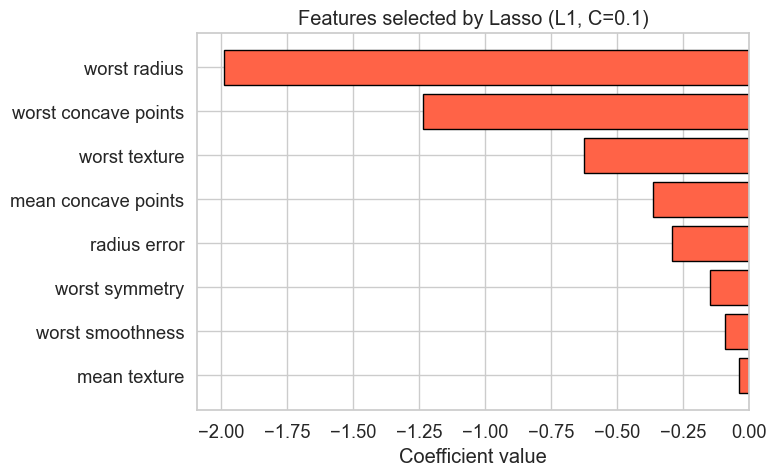


8 out of 30 features retained.


In [16]:
lr_l1 = LogisticRegression(penalty="l1", C=0.1, max_iter=5000, solver="saga")
lr_l1.fit(X_train_s, y_train)

coefs = lr_l1.coef_.ravel()
nonzero_mask = np.abs(coefs) > 1e-6
selected_features = np.array(data.feature_names)[nonzero_mask]
selected_coefs = coefs[nonzero_mask]

# Sort by absolute value
order = np.argsort(np.abs(selected_coefs))
selected_features = selected_features[order]
selected_coefs = selected_coefs[order]

colors = ["seagreen" if c > 0 else "tomato" for c in selected_coefs]

plt.figure(figsize=(8, 5))
plt.barh(selected_features, selected_coefs, color=colors, edgecolor="k")
plt.xlabel("Coefficient value")
plt.title("Features selected by Lasso (L1, C=0.1)")
plt.axvline(0, color="k", linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"\n{nonzero_mask.sum()} out of {len(coefs)} features retained.")

### 3.3  Full validation curve on the real data

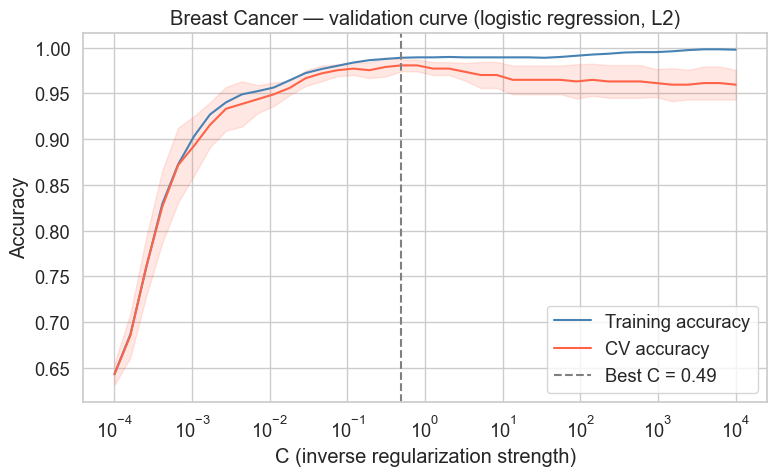

Best C = 0.49 (CV accuracy = 0.981)


In [17]:
from sklearn.model_selection import validation_curve

C_range_real = np.logspace(-4, 4, 40)

pipeline_real = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l2", max_iter=5000, solver="lbfgs")
)

train_scores_r, val_scores_r = validation_curve(
    pipeline_real, X_bc, y_bc,
    param_name="logisticregression__C",
    param_range=C_range_real,
    cv=5,
    scoring="accuracy"
)

train_mean_r = train_scores_r.mean(axis=1)
val_mean_r = val_scores_r.mean(axis=1)
val_std_r = val_scores_r.std(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(C_range_real, train_mean_r, label="Training accuracy",
         color="steelblue")
plt.plot(C_range_real, val_mean_r, label="CV accuracy", color="tomato")
plt.fill_between(C_range_real, val_mean_r - val_std_r,
                 val_mean_r + val_std_r, alpha=0.15, color="tomato")

best_idx_r = np.argmax(val_mean_r)
plt.axvline(C_range_real[best_idx_r], color="grey", linestyle="--",
            label=f"Best C = {C_range_real[best_idx_r]:.2f}")

plt.xscale("log")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Accuracy")
plt.title("Breast Cancer — validation curve (logistic regression, L2)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best C = {C_range_real[best_idx_r]:.2f} "
      f"(CV accuracy = {val_mean_r[best_idx_r]:.3f})")